<a href="https://colab.research.google.com/github/ATengkuuu/UAS_BigDataDanMining/blob/main/UAS_BDDM_5518.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Nama : Agi Mhammad Tengku A
#NIM : 23.11.5518

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import pickle


#Load Dataset

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving cardio_train.csv to cardio_train.csv


In [ ]:
df = pd.read_csv('cardio_train.csv')

df.head()


,id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio
0,0;18393;2;168;62.0;110;80;1;1;0;0;1;0
1,1;20228;1;156;85.0;140;90;3;1;0;0;1;1
2,2;18857;1;165;64.0;130;70;3;1;0;0;0;1
3,3;17623;2;169;82.0;150;100;1;1;0;0;1;1
4,4;17474;1;156;56.0;100;60;1;1;0;0;0;0


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 1 columns):
 #   Column                                                                             Non-Null Count  Dtype 
---  ------                                                                             --------------  ----- 
 0   id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio  70000 non-null  object
dtypes: object(1)
memory usage: 547.0+ KB


In [ ]:
df.describe()


,id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio
count,70000
unique,70000
top,99974;19652;1;165;72.0;120;80;1;1;0;0;1;0
freq,1


#DATA PREPROCESSING

In [ ]:
# The original dataframe `df` was loaded incorrectly, resulting in a single column
# where all data is stored as semicolon-separated strings.
# This part of the code attempts to re-parse the dataframe correctly within this cell
# before dropping the 'id' column.

# Split the single column into multiple columns
split_data = df.iloc[:, 0].str.split(';', expand=True)

# Extract column names from the single original column name
column_names = df.columns[0].split(';')

# Assign the extracted column names to the new split data
split_data.columns = column_names

# Overwrite the original dataframe with the correctly parsed data
df = split_data

# Now that 'df' is correctly parsed, drop the 'id' column
df.drop(columns=['id'], inplace=True)

In [ ]:
df['age'] = df['age'].astype(int) / 365
df['age'] = df['age'].astype(int)

In [ ]:
df.isnull().sum()


,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0
alco,0


#EXPLORATORY DATA ANALYSIS (EDA)

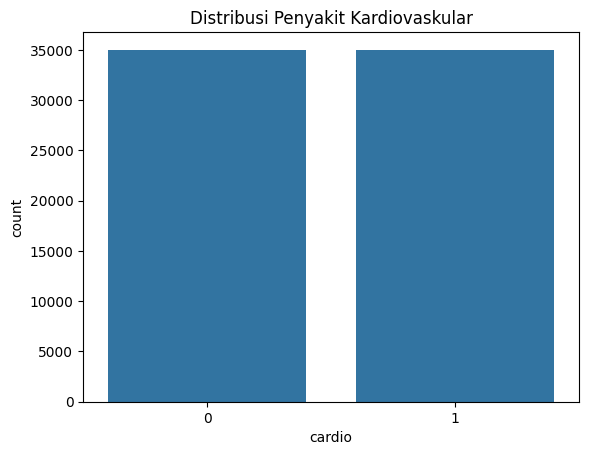

In [ ]:
sns.countplot(x='cardio', data=df)
plt.title('Distribusi Penyakit Kardiovaskular')
plt.show()


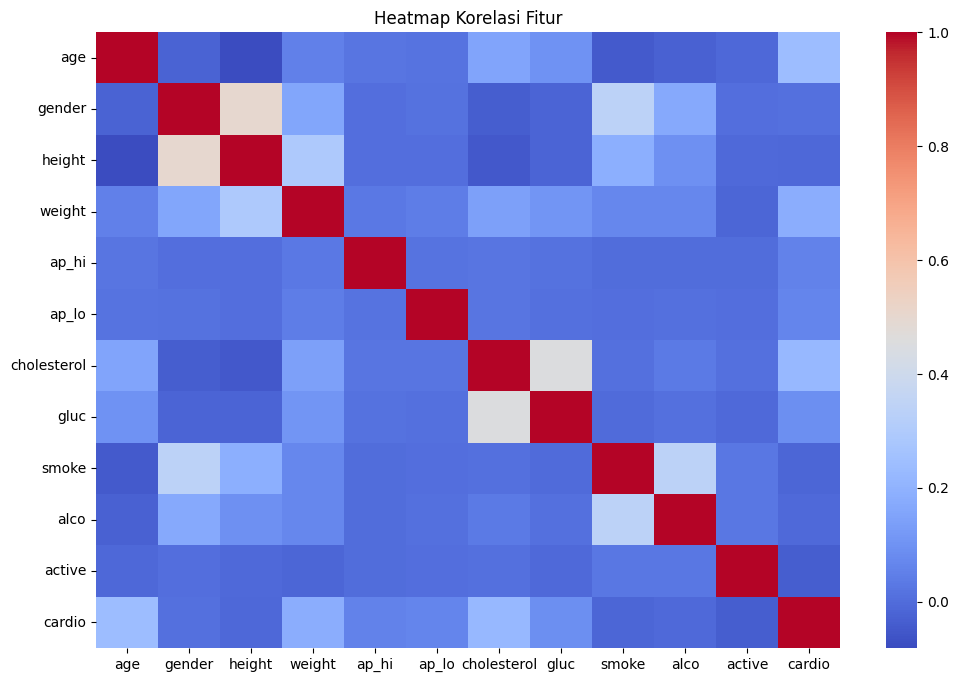

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Heatmap Korelasi Fitur')
plt.show()


#SELEKSI FITUR (Chi-Square)

In [ ]:
X = df.drop('cardio', axis=1)
y = df['cardio']

# Convert all feature columns in X to numeric type
for col in X.columns:
    X[col] = pd.to_numeric(X[col])

# Convert the target variable y to numeric type as well
y = pd.to_numeric(y)

# Filter out rows with non-physiological blood pressure values
# For chi2, features must be non-negative. Also, ap_hi should be >= ap_lo.
initial_rows = X.shape[0]
X_filtered = X[
    (X['ap_hi'] > 0) &
    (X['ap_lo'] > 0) &
    (X['ap_hi'] >= X['ap_lo'])
]
y_filtered = y.loc[X_filtered.index] # Ensure y matches the filtered X

print(f"Removed {initial_rows - X_filtered.shape[0]} rows due to invalid blood pressure readings.")

X = X_filtered
y = y_filtered

selector = SelectKBest(score_func=chi2, k=8)
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
selected_features

Removed 1256 rows due to invalid blood pressure readings.


Index(['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke',
       'active'],
      dtype='object')

#SPLIT DATA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features],
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


#STANDARDISASI

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#MODELING

Logistic Regression (Baseline)

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)


Random Forest (Model Utama)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


#EVALUASI MODEL

In [ ]:
print("Logistic Regression")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall   :", recall_score(y_test, y_pred_lr))
print("F1-score :", f1_score(y_test, y_pred_lr))


Logistic Regression
Accuracy : 0.7206342279438505
Precision: 0.7387169568020632
Recall   : 0.673673379391445
F1-score : 0.7046974705927578


In [ ]:
print("Random Forest")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1-score :", f1_score(y_test, y_pred_rf))


Random Forest
Accuracy : 0.6945959706160448
Precision: 0.700925925925926
Recall   : 0.667646626488314
F1-score : 0.6838816532409847


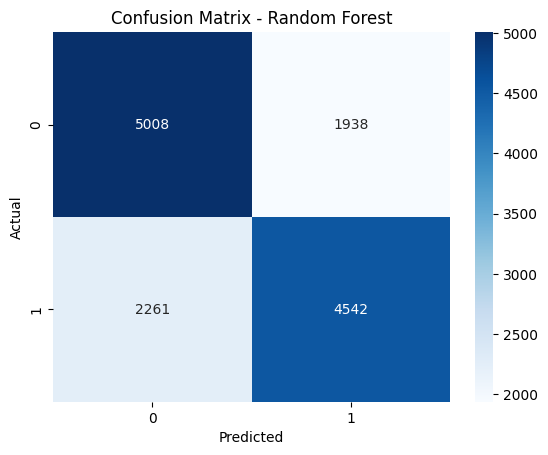

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#SIMPAN MODEL

In [ ]:
with open('cardio_model.pkl', 'wb') as file:
    pickle.dump(rf, file)


In [ ]:
from google.colab import files

files.download('cardio_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>